In [ ]:
import http.client

conn = http.client.HTTPSConnection("yh-finance.p.rapidapi.com")

headers = {
    'X-RapidAPI-Key': "07657151a4msh26586fc8fabff68p1e7e8ajsn1c82bf8a9629",
    'X-RapidAPI-Host': "yh-finance.p.rapidapi.com"
    }

conn.request("GET", "/stock/v2/get-balance-sheet?symbol=AMRN&region=US", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

In [21]:
# import necessary library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

In [22]:
d= pd.read_csv("08_04.csv")
# d = d.drop(["NaN"], axis = 0)
d= d.set_index("Profit & Loss account of Reliance Industries (in Rs. Cr.)")
# d= d.T
d=d.dropna(thresh=1)
d= d.T
d = d.dropna(thresh=1)
d= d.drop([np.NaN], axis=1)
# Replace commas with empty strings in all columns
d = d.replace(',', '', regex=True)

# Convert all columns to numeric data type
d = d.apply(pd.to_numeric)

In [23]:
# Calculate the correlation matrix
corr_matrix = d.corr().abs()

# Set the threshold
threshold = 0.7

# Identify highly correlated features
high_corr_features = np.where(corr_matrix > threshold)

# Remove highly correlated features
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
for feature in high_corr_features:
    d.drop(feature[1], axis=1 ,inplace=True ,errors='ignore')
    
# Print the modified dataset
#print(df)


In [24]:
sample_count, feature_count = d.shape

In [25]:
dataset = d
X = dataset.iloc[:, :-1].values #get a copy of dataset exclude last column
y = dataset.iloc[:, 1].values #get array of dataset in column 1st

# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)


# Fitting Simple Linear Regression to the Training set

regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)


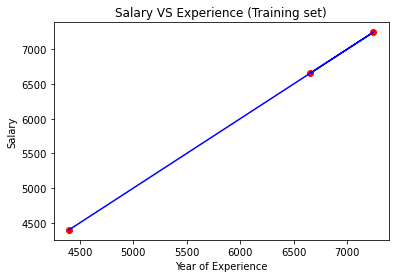

In [26]:
# Visualizing the Training set results
viz_train = plt
viz_train.scatter(X_train[:,1], y_train, color='red')
viz_train.plot(X_train[:,1], regressor.predict(X_train), color='blue')
viz_train.title('Salary VS Experience (Training set)')
viz_train.xlabel('Year of Experience')
viz_train.ylabel('Salary')
viz_train.show()



In [27]:
d

Profit & Loss account of Reliance Industries (in Rs. Cr.),Revenue From Operations [Gross],Less: Excise/Sevice Tax/Other Levies,Other Income,Changes In Inventories Of FGWIP And Stock In Trade,Exceptional Items,Less: MAT Credit Entitlement
Mar 08,143004.98,5495.54,2198.32,-1533.93,0.0,0.0
Mar 07,120431.10,6654.68,325.76,-696.92,0.0,0.0
Mar 06,90937.94,8246.67,591.11,-2120.16,0.0,0.0
Mar 05,73710.46,7245.27,1551.68,524.35,0.0,0.0
Mar 04,56470.84,4397.40,1422.76,605.41,0.0,0.0


In [28]:
# Replace commas with empty strings in all columns
d = d.replace(',', '', regex=True)

# Convert all columns to numeric data type
d = d.apply(pd.to_numeric)

In [29]:
d

Profit & Loss account of Reliance Industries (in Rs. Cr.),Revenue From Operations [Gross],Less: Excise/Sevice Tax/Other Levies,Other Income,Changes In Inventories Of FGWIP And Stock In Trade,Exceptional Items,Less: MAT Credit Entitlement
Mar 08,143004.98,5495.54,2198.32,-1533.93,0.0,0.0
Mar 07,120431.10,6654.68,325.76,-696.92,0.0,0.0
Mar 06,90937.94,8246.67,591.11,-2120.16,0.0,0.0
Mar 05,73710.46,7245.27,1551.68,524.35,0.0,0.0
Mar 04,56470.84,4397.40,1422.76,605.41,0.0,0.0


In [30]:
d["Other Income"]

Mar 08    2198.32
Mar 07     325.76
Mar 06     591.11
Mar 05    1551.68
Mar 04    1422.76
Name: Other Income, dtype: float64